In [1]:

!pip install tensorflow-gpu==2.1.0

!pip install keras==2.3.1

Found existing installation: tensorflow 2.8.0
Uninstalling tensorflow-2.8.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.8.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/uninstall.py", line 86, in run
    auto_confirm=options.yes, verbose=self.verbosity > 0,
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/req/req_install.py", line 658, in uninstall
    uninst

In [15]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

2.8.0
2.8.0


In [17]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2

input_img = keras.Input(shape=img_shape)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [18]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])


In [19]:
############ The decoder ##################
# This is the input where we will feed `z`.
decoder_input = layers.Input(K.int_shape(z)[1:])
# Upsample to the correct number of units
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
decfm1 =x

In [20]:
# Reshape into an image of the same shape as before our last `Flatten` layer
x = layers.Reshape(shape_before_flattening[1:])(x)
decfm2=x

In [21]:
# We then apply then reverse operation to the initial
# stack of convolution layers: a `Conv2DTranspose` layers
# with corresponding parameters.
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
decfm3=x

In [22]:
# We end up with a feature map of the same size as the original input.
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)
decfm4=x

In [23]:
# This is our decoder model.
decoder = Model(decoder_input, x)
# We then apply it to `z` to recover the decoded `z`.
z_decoded = decoder(z)

In [24]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x
# We call our custom layer on the input and the decoded output,
# to obtain the final model output.
y = CustomVariationalLayer()([input_img, z_decoded])

In [31]:
############## read normalized minst data ####################

from keras.datasets import mnist

(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

In [32]:
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

vae.fit(x=x_train, y=None, shuffle=True, epochs=2, batch_size=batch_size, validation_data=(x_test, None))

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 28, 28, 32)   320         ['input_4[0][0]']                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 14, 14, 64)   18496       ['conv2d_9[0][0]']               
                                                                                                  
 conv2d_11 (Conv2D)             (None, 14, 14, 64)   36928       ['conv2d_10[0][0]']              
                                                                                            

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


60000/60000 [==============================] - 380s 6ms/sample - loss: 0.2075 - val_loss: 0.1960
Epoch 2/2
60000/60000 [==============================] - 378s 6ms/sample - loss: 0.1931 - val_loss: 0.1903


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


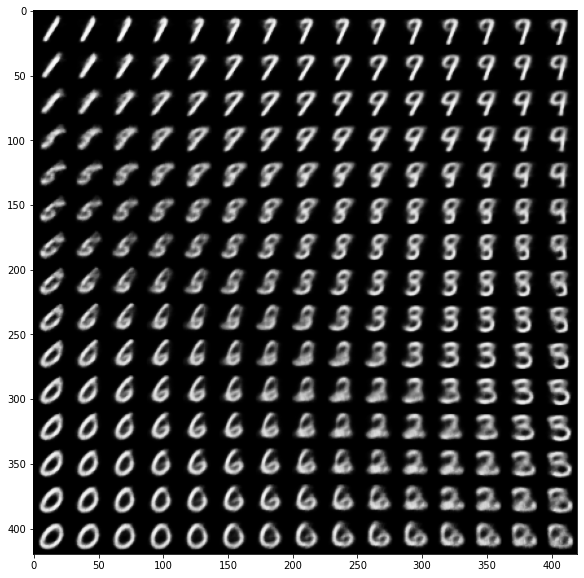

In [33]:
import matplotlib.pyplot as plt
from scipy.stats import norm

n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()
